# Exploring the Northwind database

In [1]:
import sqlite3

In [2]:
#Instantiate connection and cursor
con = sqlite3.connect('Northwind_small.sqlite')
c = con.cursor()

## Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

### Question 1.1: Do discounts have a statistically significant effect on the number of products customers order? 

First, we will list all of the tables in the database to see which ones are relevant to the question.

In [3]:
c.execute('''SELECT name FROM sqlite_master WHERE type='table';''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

It seems only one is necessary to extract product quantity and discount data:
* Order Details

Before we dig into the data, we should define our null and alternative hypothesis.

**H<sub>0</sub>:** μ<sub>non</sub> = μ<sub>dis</sub>

**H<sub>1</sub>:** μ<sub>non</sub> ≠ μ<sub>dis</sub>

**$\alpha$:** 0.05

**μ<sub>non</sub>:** mean # of products in non-discounted order

**μ<sub>dis</sub>:** mean # of products in discounted order

**n<sub>non</sub>**: 450

**n<sub>dis</sub>**: 380


In [4]:
#We will load the 'Order' table to get some example data
import pandas as pd
q1 = pd.DataFrame(c.execute('''SELECT * FROM [Order]''').fetchall())

#Copy column names from SQL database to Pandas DataFrame
q1.columns = [d[0] for d in c.description]

In [5]:
q1.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


The orders table is now in a usable condition, but we will need to join it with 'Order Details' to get the discount information. We will take a look at that table now.

In [6]:
#To make fetching and displaying arbitrary tables from our database easier, 
#we will define a function
def table_fetcher(table_name, limit=0):
    query = f'''SELECT * FROM {table_name}'''
    df = pd.DataFrame(c.execute(query).fetchall())
    df.columns = [d[0] for d in c.description]
    #return entire dataframe if zero is entered as the limit
    if limit == 0:
        return df
    #otherwise, return the number of lines specified
    else:
        return df.head(limit)

In [7]:
#Fetch the 'OrderDetail' table to examine it
table_fetcher('OrderDetail', 10)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10248/42,10248,42,9.8,10,0.00
2,10248/72,10248,72,34.8,5,0.00
3,10249/14,10249,14,18.6,9,0.00
4,10249/51,10249,51,42.4,40,0.00
5,10250/41,10250,41,7.7,10,0.00
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05


If we take 'number of products customers order' to mean the number of products they buy in a particular order, rather than the entire purchasing history over the time they are a customer, this table may actually have all the info we need. Orders are uniquely identified with 'OrderId', number of products in a given order can be calculated with 'ProductId' and 'Quantity', and total order discount can be calculated by averaging 'Discount' across the entire quantity (or value) of items. 

In [8]:
#copying table into variable for question 1
q1 = table_fetcher('OrderDetail')

In [9]:
#Get the number of unique orders in the DataFrame
print(len(q1['OrderId'].unique()))

830


In [10]:
#Sort the DataFrame by 'OrderId' to make iterating through the data easier
q1.sort_values('OrderId', inplace=True)

In [11]:
#Set last_order_id to something that is very unlikely to ever be an order ID
last_order_id = -1

#Set current index for the new DataFrame so it starts at index 0 when 1 is added
#on the condition of encountering a new row in the old DataFrame
q1_processed_index = -1

#Create new DataFrame with relevant columns
q1_processed = pd.DataFrame(columns=['order_id', 'total_quantity', 'free_products', 'total_value', 'dollars_off'])
#Iterate through rows in old dataframe
for index, data in q1.iterrows():
    #Extract data from each row into variables
    order_id = int(data[1])
    total_quantity = int(data[4])
    price = data[3]
    discount = data[5]
    #Calculate total value of products in row
    total_value = float(total_quantity * price)
    #Calculate number of dollars off for row by multiplying total value by discount
    dollars_off = float(discount * total_value)
    #Calculate number of free products for row by multiplying number of products by discount
    free_products = float(discount * total_quantity)
    #Check if row contains the same order id as the previous one
    if data[1] != last_order_id:
        #If so, add 1 to the new DataFrame index variable
        q1_processed_index += 1
        #Take all the calculated values and place them in the new DataFrame row
        q1_processed.loc[q1_processed_index] = [order_id, total_quantity, free_products, total_value, dollars_off] 
    else: 
        #Otherwise, add the new values to the existing values for that order id
        new_total_quantity = total_quantity + q1_processed.loc[q1_processed_index][1]
        new_free_products = free_products + q1_processed.loc[q1_processed_index][2]
        new_total_value = total_value + q1_processed.loc[q1_processed_index][3]
        new_dollars_off = dollars_off + q1_processed.loc[q1_processed_index][4]
        q1_processed.loc[q1_processed_index] = [order_id, new_total_quantity, new_free_products, new_total_value, new_dollars_off]
    #Update last order id variable so the script knows what order id it processed in the last loop
    last_order_id = order_id
#Display a sample of results
q1_processed.head()

,order_id,total_quantity,free_products,total_value,dollars_off
0,10248.0,27.0,0.00,440.0,0.00
1,10249.0,49.0,0.00,1863.4,0.00
2,10250.0,60.0,7.50,1813.0,260.40
3,10251.0,41.0,1.05,670.8,16.74
4,10252.0,105.0,3.25,3730.0,132.10


In [12]:
#Divide 'dollars_off' by 'total_value' to get the dollar discount rate
q1_processed['dollar_discount'] = q1_processed['dollars_off']/q1_processed['total_value']

In [13]:
#Divide 'free_products' by 'total_quantity' to get the product discount
#(portion of products that were technically free)
q1_processed['product_discount'] = q1_processed['free_products']/q1_processed['total_quantity']

In [14]:
q1_processed.head()

,order_id,total_quantity,free_products,total_value,dollars_off,dollar_discount,product_discount
0,10248.0,27.0,0.00,440.0,0.00,0.000000,0.000000
1,10249.0,49.0,0.00,1863.4,0.00,0.000000,0.000000
2,10250.0,60.0,7.50,1813.0,260.40,0.143629,0.125000
3,10251.0,41.0,1.05,670.8,16.74,0.024955,0.025610
4,10252.0,105.0,3.25,3730.0,132.10,0.035416,0.030952


In [15]:
#Import pyplot and create a scatter plot of the relationship
#between 'dollar_discount' and 'product_discount'
import matplotlib.pyplot as plt
plt.scatter(q1_processed['dollar_discount'], q1_processed['product_discount'])
plt.title('dollar_discount versus product_discount')
plt.xlabel('dollar_discount')
plt.ylabel('product_discount')
plt.show()

<Figure size 640x480 with 1 Axes>

I'm not sure which of these metrics of 'discountedness' is more useful, but to answer question 1, we only need to compare the distributions of discounted and non-discounted orders.

In [16]:
#Create separate dataframes with discounted and non-discounted orders
q1_orders_with_discount = q1_processed.loc[q1_processed['dollar_discount']>0, ['total_quantity']]
q1_orders_without_discount = q1_processed.loc[q1_processed['dollar_discount']==0, ['total_quantity']]

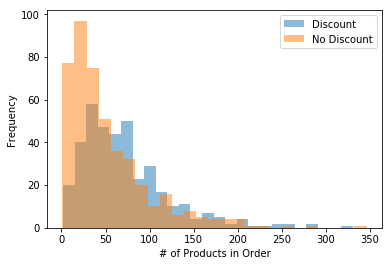

In [17]:
#Plot overlapping histograms of the two populations
plt.hist(q1_orders_with_discount.values, alpha=0.5, label='Discount', bins=25)
plt.hist(q1_orders_without_discount.values, alpha=0.5, label='No Discount', bins=25)
plt.legend()
plt.xlabel('# of Products in Order')
plt.ylabel('Frequency')
plt.show()

It looks like orders with and without discounts have noticeably different distributions. We will go on to examine these distributions statistically to define the relationship between discount and number of products. To be safe, we will use a **two-tailed T-test**.

In [18]:
#Import statistical packages
import numpy as np
import math
from scipy import stats

In [19]:
print(f'non: {len(q1_orders_without_discount)} \ndis: {len(q1_orders_with_discount)}')

non: 450 
dis: 380


In [20]:
#Use the scipy stats T-test function to find our p-value
q1_result = stats.ttest_ind(q1_orders_without_discount, q1_orders_with_discount, equal_var = False)
print(f't-statistic: {q1_result.statistic[0]}\np-value: {q1_result.pvalue[0]}')

t-statistic: -5.886184782446325
p-value: 5.850677815891118e-09


Comparing the resulting p-value of 5.85 * 10<sup>-9</sup> to our $\alpha$ of 0.05, we find that overall, **discounts do have a statistically significant effect on the number of products customers order**. Customers buy more when there is a discount. Now we will examine what levels of discount, if any, do not have a statistically significant effect on products ordered.

### If [discounts have statistically significant effect on # of products ordered, at what level(s) of discount?

Since we know that, overall, discounts do have an effect on # of products sold, we now need to find out what specific levels of discount have an effect.

In [21]:
#Extract all the levels of discount in the discount DataFrame
discount_distribution = q1_processed.loc[q1_processed['dollar_discount']>0, ['dollar_discount']]

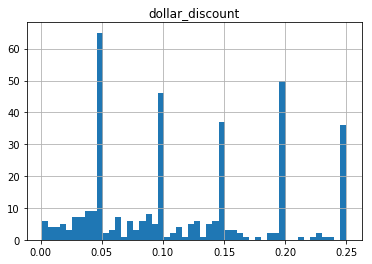

In [22]:
#Plot histogram of discount rates
discount_distribution.hist(bins=50)
plt.show()

It looks like there are spikes in the discount distribution about every 0.05, probably because these were popular levels of discount. I imagine that the values in between are from averaging the discounts of different products in an order. To find out 

In [23]:
#Preview processed DataFrame again
q1_processed.head()

,order_id,total_quantity,free_products,total_value,dollars_off,dollar_discount,product_discount
0,10248.0,27.0,0.00,440.0,0.00,0.000000,0.000000
1,10249.0,49.0,0.00,1863.4,0.00,0.000000,0.000000
2,10250.0,60.0,7.50,1813.0,260.40,0.143629,0.125000
3,10251.0,41.0,1.05,670.8,16.74,0.024955,0.025610
4,10252.0,105.0,3.25,3730.0,132.10,0.035416,0.030952


In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [25]:
q1_tukey_0 = q1_processed[q1_processed['dollar_discount']==0]['total_quantity']

In [26]:
q1_tukey_01to05 = q1_processed[(q1_processed['dollar_discount']>0) & 
    (q1_processed['dollar_discount']<=0.05)]['total_quantity']

In [27]:
q1_tukey_05to10 = q1_processed[(q1_processed['dollar_discount']>0.05) & 
    (q1_processed['dollar_discount']<=0.10)]['total_quantity']

In [28]:
q1_tukey_10to15 = q1_processed[(q1_processed['dollar_discount']>0.10) & 
    (q1_processed['dollar_discount']<=0.15)]['total_quantity']

In [29]:
q1_tukey_15to20 = q1_processed[(q1_processed['dollar_discount']>0.15) & 
    (q1_processed['dollar_discount']<=0.20)]['total_quantity']

In [30]:
q1_tukey_20to25 = q1_processed[(q1_processed['dollar_discount']>0.20) & 
    (q1_processed['dollar_discount']<=0.25)]['total_quantity']

In [31]:
q1_tukey_25up = q1_processed[q1_processed['dollar_discount']>0.25]['total_quantity']

In [32]:
q1_v = np.concatenate([
    q1_tukey_0, 
    q1_tukey_01to05, 
    q1_tukey_05to10, 
    q1_tukey_10to15, 
    q1_tukey_15to20, 
    q1_tukey_20to25,
    q1_tukey_25up])

In [33]:
l1 = ['0 discount'] * len(q1_tukey_0)
l2 = ['>0 to 0.05 discount'] * len(q1_tukey_01to05)
l3 = ['>0.05 to 0.10 discount'] * len(q1_tukey_05to10)
l4 = ['>0.10 to 0.15 discount'] * len(q1_tukey_10to15)
l5 = ['>0.15 to 0.20 discount'] * len(q1_tukey_15to20)
l6 = ['>0.20 to 0.25 discount'] * len(q1_tukey_20to25)
l7 = ['>0.25 discount'] * len(q1_tukey_25up)

q1_labels = l1 + l2 + l3 + l4 + l5 + l6 + l7

In [34]:
q1_tukey_results = pairwise_tukeyhsd(q1_v, q1_labels, 0.05)

In [35]:
print(q1_tukey_results)

              Multiple Comparison of Means - Tukey HSD,FWER=0.05              
        group1                 group2         meandiff  lower    upper  reject
------------------------------------------------------------------------------
      0 discount        >0 to 0.05 discount   17.7004   2.7836  32.6171  True 
      0 discount       >0.05 to 0.10 discount 19.9805   3.3985  36.5624  True 
      0 discount       >0.10 to 0.15 discount 18.8394   0.3298   37.349  True 
      0 discount       >0.15 to 0.20 discount 21.9886   2.8515  41.1256  True 
      0 discount       >0.20 to 0.25 discount 28.7089   6.901   50.5169  True 
 >0 to 0.05 discount   >0.05 to 0.10 discount  2.2801  -17.907  22.4672 False 
 >0 to 0.05 discount   >0.10 to 0.15 discount  1.1391  -20.6592 22.9373 False 
 >0 to 0.05 discount   >0.15 to 0.20 discount  4.2882  -18.0453 26.6217 False 
 >0 to 0.05 discount   >0.20 to 0.25 discount 11.0086  -13.652  35.6692 False 
>0.05 to 0.10 discount >0.10 to 0.15 discount  -1.14

Based on this output, we can reasonably conclude that all levels of discount have a statistically significant relationship with the quantity of items in an order (P<0.05).

## Question 2: Do orders contain a statistically significant different value of products when the employee responsible for the sale has the same phone area code as the customer?

Four tables are relevant to this question:

* Orders
* OrderDetail
* Customer
* Employee

We define our null and alternative hypothesis:

**H<sub>0</sub>:** μ<sub>same</sub> = μ<sub>diff</sub>

**H<sub>1</sub>:** μ<sub>same</sub> ≠ μ<sub>diff</sub>

**$\alpha$:** 0.05

**μ<sub>same</sub>:** mean value of orders where customer/employee pairs had same phone area code

**μ<sub>diff</sub>:** mean value of orders where customer/employee pairs had different phone area code

**n<sub>same</sub>**: 12

**n<sub>diff</sub>**: 789


In [75]:
#Open SQL query file to search for orders with matching customer/employee area codes
file = open('q2_matching-area-codes.sql','r')
matching_area_codes = file.read()
file.close()

In [76]:
#Execute SQL query
matching_results = c.execute(matching_area_codes).fetchall()

In [77]:
#Open SQL query file to search for orders with non-matching customer/employee area codes
file = open('q2_nonmatching-area-codes.sql', 'r')
nonmatching_area_codes = file.read()
file.close()

In [78]:
#Execute SQL query
nonmatching_results = c.execute(nonmatching_area_codes).fetchall()

In [79]:
#Check results
matching_results

[(2296.0,),
 (956.675,),
 (1388.5,),
 (764.3,),
 (1180.88,),
 (2071.2,),
 (996.0,),
 (468.45,),
 (1416.0,),
 (3523.4,),
 (1924.25,),
 (8902.5,)]

The returned list seems to contain tuples with our number inside. We will write a de-tupling function to extract the value.

In [80]:
def detupler(list):
    return [x[0] for x in list]

In [81]:
matching_results_cleaned = detupler(matching_results)

In [82]:
nonmatching_results_cleaned = detupler(nonmatching_results)

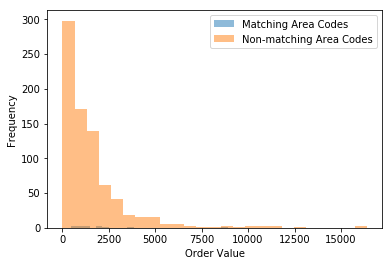

In [83]:
'''
Plot distributions of order value for customer/employee
pairs with matching and nonmatching area codes
'''
plt.hist(matching_results_cleaned, alpha=0.5, label='Matching Area Codes', bins=25)
plt.hist(nonmatching_results_cleaned, alpha=0.5, label='Non-matching Area Codes', bins=25)
plt.legend()
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

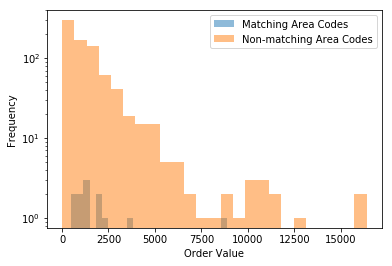

In [84]:
#Re-plot with log scale y axis
plt.hist(matching_results_cleaned, alpha=0.5, label='Matching Area Codes', bins=25)
plt.hist(nonmatching_results_cleaned, alpha=0.5, label='Non-matching Area Codes', bins=25)
plt.legend()
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [85]:
#Perform two-tailed Mann-Whitney U Test on the distributions with Scipy Stats library
q2_result = stats.mannwhitneyu(
    matching_results_cleaned, nonmatching_results_cleaned, alternative='two-sided'
)

In [74]:
#Get P-value of test
q2_result.pvalue

0.08210731477282339

Based on the test, **there is not a statistically significant different value of products ordered** when the employee responsible for the sale has the same phone area code as the customer.

**P (0.08) > $\alpha$ (0.05)**

## Question 3: Do products in the greater half by quantity sold have a statistically significant different reorder threshold than those in the lesser half by quantity sold?

Three tables are relevant to this question:
* Product
* OrderDetail
* Order

We define our null and alternative hypothesis:

**H<sub>0</sub>:** μ<sub>greater</sub> = μ<sub>lesser</sub>

**H<sub>1</sub>:** μ<sub>greater</sub> ≠ μ<sub>lesser</sub>

**$\alpha$:** 0.05

**μ<sub>greater</sub>:** mean reorder threshold of products in the greater half by quantity sold

**μ<sub>lesser</sub>:** mean reorder threshold of products in the lesser half by quantity sold

**n<sub>same</sub>**: 38

**n<sub>diff</sub>**: 38

In [48]:
q3_lesser_half = c.execute('''
  SELECT Product.ReorderLevel
    FROM Product
    JOIN OrderDetail ON Product.Id=OrderDetail.ProductId
    JOIN [Order] ON [Order].Id=OrderDetail.OrderId
GROUP BY Product.Id
ORDER BY SUM(OrderDetail.Quantity) ASC
LIMIT 38
''').fetchall()

In [49]:
q3_greater_half = c.execute('''
  SELECT Product.ReorderLevel
    FROM Product
    JOIN OrderDetail ON Product.Id=OrderDetail.ProductId
    JOIN [Order] ON [Order].Id=OrderDetail.OrderId
GROUP BY Product.Id
ORDER BY SUM(OrderDetail.Quantity) DESC
LIMIT 38
''').fetchall()

In [50]:
q3_lesser_half = detupler(q3_lesser_half)
q3_greater_half = detupler(q3_greater_half)

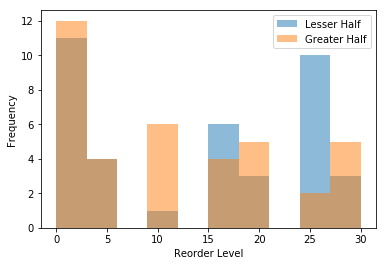

In [51]:
plt.hist(q3_lesser_half, alpha=0.5, label='Lesser Half')
plt.hist(q3_greater_half, alpha=0.5, label='Greater Half')
plt.legend()
plt.xlabel('Reorder Level')
plt.ylabel('Frequency')
plt.show()

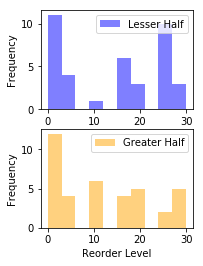

In [52]:
#Visualize data in two separate histograms for better interpretation
q3_hist_figure = plt.figure()
ax1 = q3_hist_figure.add_subplot(221)
ax2 = q3_hist_figure.add_subplot(223)

ax1.hist(q3_lesser_half, alpha=0.5, label='Lesser Half', color='Blue')
ax2.hist(q3_greater_half, alpha=0.5, label='Greater Half', color='Orange')

ax1.legend()
ax1.set_xlabel('Reorder Level')
ax1.set_ylabel('Frequency')

ax2.legend()
ax2.set_xlabel('Reorder Level')
ax2.set_ylabel('Frequency')

plt.show()

In [53]:
#Use the scipy stats T-test function to find our p-value
q3_result = stats.ttest_ind(q3_lesser_half, q3_greater_half, equal_var = False)
print(q3_result.pvalue)

0.40382632307192035


Comparing the resulting p-value of 0.40382632307192035 to our 𝛼 of 0.05, we find that **whether a product is in the greater or lesser half of products by quantity sold does have a statistically significant relationship with the reorder threshold**. 

## Question 4: Do customers with streaks of selecting the same shipper 5 or more times in a row have a statistically significant difference in lifetime sales value (loyalty)?

Three tables are relevant to this question:
* Order
* OrderDetail
* Customer

We define our null and alternative hypothesis:

**H<sub>0</sub>:** μ<sub>st</sub> = μ<sub>no</sub>

**H<sub>1</sub>:** μ<sub>st</sub> ≠ μ<sub>no</sub>

**$\alpha$:** 0.05

**μ<sub>st</sub>:** mean sales value of customers with a streak of selecting the same shipper 5 times in a row

**μ<sub>no</sub>:** mean sales value of customers without a streak of selecting the same shipper 5 times in a row

**n**: ???


In [54]:
q4 = pd.DataFrame(c.execute('''
    SELECT CustomerId, OrderDate, UnitPrice, Quantity, Discount, ShipVia
      FROM [Order]
INNER JOIN Customer ON [Order].CustomerId = Customer.Id
INNER JOIN OrderDetail on [Order].Id = OrderDetail.OrderId
  ORDER BY CustomerId, OrderDate
''').fetchall())

#Copy column names from SQL database to Pandas DataFrame
q4.columns = [d[0] for d in c.description]

In [55]:
#Preview DataFrame
print(q4)

     CustomerId   OrderDate  UnitPrice  Quantity  Discount  ShipVia
0         ALFKI  2013-08-25      45.60        15      0.25        1
1         ALFKI  2013-08-25      18.00        21      0.25        1
2         ALFKI  2013-08-25      12.00         2      0.25        1
3         ALFKI  2013-10-03      43.90        20      0.00        2
4         ALFKI  2013-10-13      10.00         6      0.00        1
5         ALFKI  2013-10-13      18.00        15      0.00        1
6         ALFKI  2014-01-15      55.00        15      0.00        3
7         ALFKI  2014-01-15      13.00         2      0.20        3
8         ALFKI  2014-03-16      25.00        16      0.05        1
9         ALFKI  2014-03-16      45.60         2      0.00        1
10        ALFKI  2014-04-09      13.25        40      0.05        1
11        ALFKI  2014-04-09      21.50        20      0.00        1
12        ANATR  2012-09-18      28.80         1      0.00        3
13        ANATR  2012-09-18      12.00         5

In [56]:
q4_processed = pd.DataFrame(columns=['CustomerId', 'CustomerValue', 'ShippingStreak'])

#INSTANTIATE SOME VARIABLES
last_customer_id = ''
last_ship_id = 0
running_customer_value = 0
ship_streak = 1
q4_processed_index = 0

#ITERATE THROUGH ROWS IN q4
for index, data in q4.iterrows():
    
    #Move values from 'data' to scrutable variables
    row_value = data[2] * data[3] * (1-data[4])
    customer_id = data[0]
    ship_id = data[5]
    
    if customer_id == last_customer_id:
        running_customer_value += row_value
        if ship_id == last_ship_id:
            ship_streak += 1
        else:
            ship_streak = 1
    else:
        q4_processed.loc[q4_processed_index] = [last_customer_id, running_customer_value, ship_streak]
        running_customer_value = row_value
        ship_streak = 1
        q4_processed_index += 1
          
    #PRESERVE MEMORY OF PREVIOUS ITERATION
    last_customer_id = customer_id
    last_ship_id = ship_id

#Add last shipper after q4 finishes iterating, because row iteration ends too soon
q4_processed.loc[q4_processed_index+1] = [last_customer_id, running_customer_value, ship_streak]

#Remove useless start row (artifact of iteration process)
q4_processed = q4_processed[1:]

#Preview DataFrame
q4_processed.head()

,CustomerId,CustomerValue,ShippingStreak
1,ALFKI,4273,4
2,ANATR,1402.95,5
3,AROUT,13390.7,7
4,BERGS,24927.6,6
5,BLAUS,3239.8,3


In [57]:
#Check the math to ensure the algorithm calculated value properly
test = q4[q4['CustomerId']=='WOLZA']
sum(test['UnitPrice'] * test['Quantity'] * (1-test['Discount']))

3531.95

In [58]:
#Separate DataFrame into shippers with and without streaks of using the same shipper 5x
q4_processed_streak = list(q4_processed[q4_processed['ShippingStreak']>=5]['CustomerValue'])

In [59]:
q4_processed_nostreak = list(q4_processed[q4_processed['ShippingStreak']<5]['CustomerValue'])

In [60]:
q4_processed_streak

[1402.95,
 13390.650000000001,
 24927.577499999996,
 6089.9,
 104874.9785,
 4107.55,
 29567.5625,
 3063.2,
 1992.0500000000002,
 522.5,
 3076.4725,
 649.0,
 12496.2,
 5044.9400000000005,
 6664.810000000001,
 110277.30500000001,
 51097.80049999999,
 5735.150000000001,
 104361.95000000001,
 16817.0975,
 24088.78,
 4778.139999999999,
 9588.425,
 15648.702499999998]

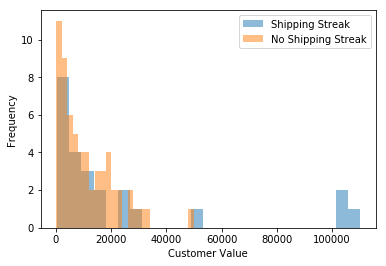

In [61]:
plt.hist(q4_processed_streak, alpha=0.5, label='Shipping Streak', bins=25)
plt.hist(q4_processed_nostreak, alpha=0.5, label='No Shipping Streak', bins=25)
plt.legend()
plt.xlabel('Customer Value')
plt.ylabel('Frequency')
plt.show()

In [62]:
q4_result = stats.ttest_ind(q4_processed_streak, q4_processed_nostreak, equal_var = False)
print(q4_result.pvalue)

0.09273245000580074


Comparing the resulting p-value of 0.09273245000580074 to our 𝛼 of 0.05, we find that **whether a customer has a streak of selecting the same shipper 5 times in a row does not have a statistically significant relationship with that customer's lifetime dollar value**. 